In [ ]:
# Downloaden van de nodige nltk bronnen
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')

In [10]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:60px; font-weight:bold;">CineClassify</div>
</div>
<br>
<p>In een wereld waar films in overvloed zijn, is er een groeiende behoefte om ze gemakkelijk en duidelijk te kunnen classificeren. Veel kijkers hebben geen goed overzicht over alle mengende genres en de vele nuances. Dit kan het zoeken van een leuke film voor op de vrijdagavond vanuit de Netflix catalogus of een trip naar de bios onnodig gecompliceerd maken.  

Daarom heeft het nieuwe filmplatform “CineClassify” als doel om films automatisch te laten classificeren in verschillende genres en een duidelijke gids te brengen naar de kijkers. Om dit doel te bereiken hebben ze een data-science team ingehuurd om een model te maken die genres kan gaan voorspellen. Aan de hand van verschillende gegevens, bijv. cast, regisseur, reviews, etc., moet het mogelijk worden gemaakt om filmliefhebbers over de wereld te helpen om eenvoudiger films te vinden die passen bij hun smaak. 

In dit notebook werken we aan onze opdracht van CineClassify. Er zal een pipeline worden gebouwd om de data in te laden en er een dataframe van te maken. Dit dataframe kan worden gebruikt om de data duidelijk in te zien voor het datascience team.</p>
<br>
<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Inhoudsopgave</div>
    <a name='begin'></a>
</div>

1. [Importeren van libaries](#start)
2. [IMDb Webscraping](#ws)
3. [Database: Movie Summaries](#db)
4. [API](#api)
5. [Preprocessing en Feature Engineering](#tr)
6. [Opzetten van de Pipeline](#pipe)
7. [Aantonen dat de Pipeline werkt](#toon)

<br>

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Importeren van libraries</div>
    <a name='start'></a>
</div>

In [45]:
# Importeren standaard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Instellen van maximaal aantal rijen en kolommen
pd.set_option("display.max_rows", 110)
pd.set_option("display.max_columns", 110)

# Importeren webscraping libaries
import requests
from bs4 import BeautifulSoup
import regex as re

# Importeren time-out libraries
from time import sleep
from random import randint

# Importeren Database libraries
import tarfile
import os
import urllib.request
from io import BytesIO
import sqlite3

# Importeren API librabries
import requests

# Importeren Preprocessing libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import json
from tqdm.notebook import tqdm_notebook

# Importeren FE libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Importeren Modeleer libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">IMDb Webscraping</div>
    <a name='ws'></a>
</div>

Om een deel van de data te krijgen is het nodig om data te verkrijgen van het internet. Dit wordt gedaan door middel van een techniek genaamd webscraping. Door middel van de BeautifulSoup library voor Python is het gemakkelijk gemaakt om deze stappen te ondernemen. Door het bekijken van de HTML code van de website kunnen de nodige elementen gevonden worden en kan de data opgehaald worden van de website. Voordat we beginnen met het coderen van de soup worden er eerst een paar nodige elementen aangemaakt.

Om deze data te verkrijgen is er gebruik gemaakt van een webscraper. Deze webscraper is helaas niet meer bruikbaar doordat de source-code van de website volledig is veranderd. De code die gebruikt is om de data te verkrijgen is in de markdown cell gezet. Na de uitleg van de code, lezen we het csv bestand in dat gemaakt is na het uitvoeren van de code.

```py
# Aanmaken van lijsten om de data in te stoppen
titel = []
jaartal = []
lengte = []
imdb_scores = []
meta_scores = []
stemmen = []
us_omzet = []
beschrijving = []
certificaat = []
genre = []
regisseur = []
sterren = []

# Verkrijgen van de engelse namen van films
en_titel = {'Accept-Language': 'en-US, en;q=0.5'}

# Aanmaken van lijst voor pagina's
pagina = np.arange(1, 1001, 50)

# Aanmaken van de URL
url = 'https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&start='

# Zorgen dat de scraping voor elke 50 gaat
for p in pagina:
    # Pakken van URL
    p = requests.get(
        url + str(p) + '&ref_=adv_nxt', headers=en_titel
        )

    # Beginnen van de soup
    soup = BeautifulSoup(p.text, 'html.parser')

    # Zoeken van alle films op de pagina
    films = soup.find_all('div', class_='lister-item mode-advanced')

    # Wachtijd van 2 tot 10 seconden
    sleep(randint(2, 10))

    for item in films:
        # Titel
        titel.append(item.h3.a.text)

        # Jaartal
        jaartal.append(item.h3.find('span', class_='lister-item-year').text)

        # Regisseur
        regisseur.append(item.find('p', class_='').find('a').text)

        # Hoofd-acteurs
        acteurs = item.find('p', class_='').find_all('a')
        stars = []
        for tag in acteurs[-4:]:
            stars.append(tag.text)
        sterren.append(stars)

        # Leeftijd certificatie
        cert = (item.find('span', class_='certificate').text
                if item.p.find('span', class_='certificate') else 'NotFound')
        certificaat.append(cert)

        # Lengte
        runtime = (item.find('span', class_='runtime').text
                    if item.p.find('span', class_='runtime') else 'NotFound')
        lengte.append(runtime)

        # Genre
        gen = (item.find('span', class_='genre').text
                if item.p.find('span', class_='genre') else 'NotFound')
        genre.append(gen)

        # IMDb rating
        imdb_scores.append(float(item.strong.text))

        # meta_scores
        m_score = (item.find('span', class_='metascore').text
                    if item.find('span', class_='metascore') else 'NotFound')
        meta_scores.append(m_score)

        # Beschrijving
        desc = item.find_all('p', class_='text-muted')
        beschrijving.append(desc[1].text)

        # Stemmen en Omzet
        so = item.find_all('span', attrs={'name':'nv'})
        stemmen.append(so[0].text)
        us_omzet.append(so[1].text if len(so) > 1 else '-')

    print("-- Iteratie van loop voltooid --")

# Aanmaken van een dataframe
films = pd.DataFrame(
    {'Titel' : titel,
     'Beschrijving' : beschrijving,
     'Regisseur' : regisseur,
     'Hoofd Acteurs' : sterren,
     'Age_Rating' : certificaat,
     'Genre' : genre,
     'Jaar' : jaartal,
     'Minuten' : lengte,
     'IMDb_Score' : imdb_scores,
     'Meta_Score' : meta_scores,
     'Stemmen' : stemmen,
     'Omzet (in M)' : us_omzet}
)

# Data preprocessing van de films dataframe
# Opschonen van de omschrijving kolom
films['Beschrijving'] = films['Omschrijving'].str.strip()

# Opschonen van de acteurs kolom
films['Hoofd Acteurs'] = films['Hoofd Acteurs'].astype(str)\
                            .replace({'\'': '', '\[|\]': ''}, regex=True)

# Opschonen van de genres kolom
films['Genre'] = films['Genre'].str.strip()

# Opschonen van de Jaar kolom
films['Jaar'] = films['Jaar'].str.extract('(\d+)').astype(int)

# Opschonen van de Minuten kolom
films['Minuten'] = films['Minuten'].str.extract('(\d+)').astype(int)

# Opschonen van de Meta_score kolom
films['Meta_Score'] = films['Meta_Score'].str.extract('(\d+)')

# Omzetten naar float en NotFound veranderen naar NaN
films['Meta_Score'] = pd.to_numeric(films['Meta_Score'], errors='coerce')

# Opschonen van de Stemmen kolom
films['Stemmen'] = films['Stemmen'].str.replace(',', '').astype(int)

# Opschonen van Omzet kolom
# Weghalen van '$' en 'M'
films['Omzet (in M)'] = films['Omzet (in M)'].map(lambda x: x.lstrip('$').rstrip('M'))

# Omzetten naar float en NotFound veranderen naar NaN
films['Omzet (in M)'] = pd.to_numeric(films['Omzet (in M)'], errors='coerce')

films.to_csv('IMDb_data.csv')
```

Met de bovenstaande code is het gelukt om de data van de voorgaande versie van IMDb te extraheren en de data alvast te preprocessen. Deze data is vervolgens in een CSV bestand gezet die nu zal worden ingeladen.

Later is besloten om enkel drie kolommen te behouden in deze dataset. Daarom missen er heel wat kolommen uit de oorspronkelijke code met het bestand. De code om deze kolommen eruit te halen is te vinden in het hoofdstuk preprocessing.

In [2]:
# Inladen van IMDb Data
webscraper = pd.read_csv('IMDb_data.csv')

# Tonen data
display(webscraper.dtypes)
display(webscraper)

Titel           object
Beschrijving    object
Genre           object
dtype: object

,Titel,Beschrijving,Genre
0,The Shawshank Redemption,"Over the course of several years, two convicts...",Drama
1,The Godfather,"Don Vito Corleone, head of a mafia family, dec...",Crime
2,The Dark Knight,When the menace known as the Joker wreaks havo...,Action
3,Schindler's List,"In German-occupied Poland during World War II,...",Biography
4,The Lord of the Rings: The Return of the King,Gandalf and Aragorn lead the World of Men agai...,Action
...,...,...,...
995,When Marnie Was There,"Due to 12-year-old Anna's asthma, she's sent t...",Animation
996,Control,"A profile of Ian Curtis, the enigmatic singer ...",Biography
997,Philomena,A world-weary political journalist picks up th...,Biography
998,Shine,"Pianist David Helfgott, driven by his father a...",Biography


Het dataframe ziet er inmiddels anders uit dan dat in de code staat beschreven. De reden hiervoor is dat de uiteindelijk onnodige kolommen zijn verwijderd en vervolgens opnieuw het csv is aangemaakt in het hoofdstuk preprocessing. Door een klein overzichtsfoutje heeft het nieuwe csv bestand dezelfde naam gekregen als de oude en is de oude dus overschreven. Dit is door middel van deze code gebeurt:

```py
# Lijst voor kolommen om te behouden
cols_to_keep = ['Titel', 'Beschrijving', 'Genre']

# Alleen behouden van de nodige kolommen
films = films[cols_to_keep]

# Opslaan van aanpassingen in CSV
films.to_csv('IMDb_data.csv', index=False)
```
Het dataframe zal in deze staat ook gebruikt worden in de pipeline, dus daarvoor is er niks veranderd.

[Terug naar Inhoudsopgave](#begin)

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Database: Movie Summaries</div>
    <a name='db'></a>
</div>

Voor het Database onderdeel van de opgave, is er gebruik gemaakt van een online downloadbare bron genaamd de Movie Summary Corpus. Deze databron bevat verschillende informatie van ongeveer 42000 films. Er staat informatie over de verschillende karakters in de films, een uitgebreide omschrijving van het plot en metadata over de film. Voor dit onderzoek zal de data over de karakters niet nodig zijn en dus zal deze niet worden ingeladen. De onderstaande stukken uitleg zijn voor de data die wij gaan gebruiken. Met dank aan de README.txt die bij de download van de data zat, is het gemakkelijker om de data en de structuur te begrijpen. Voor het inladen van elk bestand is de README gebruikt om de kolomnamen aan te maken en de data op de juiste manier in te laden.
<br>
<br>
<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Bestand: plot_summaries.txt</div>
    <a name='db'></a>
</div>

Door middel van pd.read_csv is het mogelijk om text bestanden in te lezen. Bij het bekijken van het tekst bestand werd duidelijk dat de scheiding van kolommen is aangegeven door een tab. Verder is de README informatie gebruikt om de kolomnamen te maken:
- Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary. (Gekopieerd van README.txt verkregen van CMU Movie Summary Corpus, n.d.)
<br>
<br>
<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Bestand: movie.metadata.tsv</div>
</div>

Ook bij dit tsv bestand kan er gebruik worden gemaakt van de pd.read_csv functie. Bij het lezen van de README is duidelijk neergezet hoe de structuur van dit bestand eruit ziet.

Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns: (Gekopieerd van README.txt verkregen van CMU Movie Summary Corpus, n.d.)

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

<br>
<br>

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Data inladen naar database</div>
</div>

Om de data in te kunnen lezen, wordt er gebruik gemaakt van een database. Deze database zal worden aangemaakt door de corpus van het internet te downloaden, om deze vervolgens in een database in te laden. Deze taken worden gedaan met behulp van verschillende libaries, met name urllib en sqlite3. Om al deze stappen uit te voeren worden er eerst een aantal functies aangemaakt. Elke functie heeft zijn eigen doel en samen geven ze een gestreamlinede weg naar het maken van de database.

In [3]:
def downloaden_en_extraheren(url, folder):
    """
    Deze functie download een gecomprimeerd archief van de
    opgegeven URL en extraheerd de data naar een opgegeven map.

    Parameters:
    ----------
    url : str
        De URL van het te downloaden archief.

    folder : str
        Het pad naar de doelmap waarin de
        bestanden worden geëxtraheerd.

    Returns:
    ----------
    None
    """
    # Openen van de URL en lezen van de response
    response = urllib.request.urlopen(url)
    tar_data = BytesIO(response.read())

    # Downloaden en extraheren van de bestanden
    with tarfile.open(fileobj=tar_data, mode='r:gz') as tar:
        tar.extractall(path=folder)

def dataframe_naar_database(df, tabel_naam, db_loc):
    """
    Overzetten van een Pandas DataFrame naar een
    SQLite-database tabel.

    Parameters:
    ----------
    df : pandas.DataFrame
        Het DataFrame dat moet worden overgezet.

    tabel_naam : str
        De naam van de tabel in de database.

    db_loc : str
        Het pad naar de SQLite-database.

    Returns:
    ----------
    None
    """
    # Verbinden met de database
    conn = sqlite3.connect(db_loc)

    # Aanmaken van de tabel
    df.to_sql(name=tabel_naam, con=conn, if_exists='replace', index=False)

    # Pushen van verandering naar Database en stoppen connectie
    conn.commit()
    conn.close()

def query_exe(db_loc, query):
    """
    Uitvoeren van een SQL-query op de opgegeven SQLite-database
    en de resultaten omzetten naar een Pandas DataFrame.

    Parameters:
    db_loc : str
        Het pad naar de SQLite-database.

    query : str
        De SQL-query die moet worden uitgevoerd.

    Returns:
    ----------
    df : pandas.DataFrame
        Het resultaat van de query als een DataFrame.
    """
    # Verbinden met de database
    conn = sqlite3.connect(db_loc)

    # Query inlezen tot dataframe
    df = pd.read_sql_query(query, conn)

    # Sluiten van de connectie met database
    conn.close()

    return df

Met de functies aangemaakt, kunnen we de nodige parameters definieeren om de data te downloaden en in te laden in de database. 

In [4]:
# URL download
url = "http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"

# Folder path
folder = "MovieSummaries"

# Database naam
db_loc = 'movie_database.db'

# Kolommen van de data
kolommen = {
    "movie.metadata": ['Wikipedia_ID', 'Freebase_ID', 'Titel',
                       'Release_date', 'Box_office', 'Lengte',
                       'Talen', 'Landen', 'Genre'],
    "character.metadata": ['Wikipedia_ID', 'Freebase_ID', 'Release_date',
                           'Char_Name', 'Actor_DoB', 'Actor_gender', 'Actor_h',
                           'Actor_eth', 'Actor_Name', 'Actor_age',
                           'Freebase_map_ID', 'Freebase_ch_ID', 'Freebase_ac_ID'],
    "plot_summaries": ['Wikipedia_ID', 'Beschrijving'],
    "name.clusters": ['Name', 'Freebase_ID'],
    "tvtropes.clusters": ['Trope', 'Character_Data']
}

Met gebruik van deze vier parameters is het mogelijk om de nodige functies voor het downloaden van de data en het inladen in de database uit te gaan voeren.

In [5]:
# Uitvoeren van de download en extract stap
downloaden_en_extraheren(url, folder)

# Loopen over de folder met geextraheerde data
for root, dirs, files in os.walk(folder):
    for file in files:
        # Aanmaken van bestand locatie, type en de tabel naam
        file_path = os.path.join(root, file)
        file_type = 'tsv' if file.endswith(".tsv") else 'txt'
        tabel_naam = os.path.splitext(file)[0]

        # Excluderen van README.txt
        if file != "README.txt":
            print(f"Processen van {file_type.upper()} bestand: {file_path}")

            # Aangeven welke kolommen worden gebruikt
            custom_kols = kolommen.get(tabel_naam, None)

            # Aanmaken van dataframe
            df = pd.read_csv(file_path, sep='\t', names=custom_kols)

            # Dataframe transporteren naar database
            dataframe_naar_database(df, tabel_naam, db_loc)
            print(f"Tabel '{tabel_naam}' is toegevoegd")

Processen van TSV bestand: MovieSummaries\MovieSummaries\character.metadata.tsv
Tabel 'character.metadata' is toegevoegd
Processen van TSV bestand: MovieSummaries\MovieSummaries\movie.metadata.tsv
Tabel 'movie.metadata' is toegevoegd
Processen van TXT bestand: MovieSummaries\MovieSummaries\name.clusters.txt
Tabel 'name.clusters' is toegevoegd
Processen van TXT bestand: MovieSummaries\MovieSummaries\plot_summaries.txt
Tabel 'plot_summaries' is toegevoegd
Processen van TXT bestand: MovieSummaries\MovieSummaries\tvtropes.clusters.txt
Tabel 'tvtropes.clusters' is toegevoegd


Nu alle data als tabel is toegevoegd in de database, worden er een paar queries uitgevoerd. Op deze manier is het aan te tonen dat de code heeft gewerkt. De eerste is om aan te tonen dat het werkt, de tweede is het dataframe dat uiteindelijk gebruikt zal worden. Dit tweede dataframe zal vervolgens ook worden gebruikt om te kijken welke stappen van preprocessing en feature engineering nodig zijn.

In [6]:
# Aanmaken van query
query = """
    SELECT Wikipedia_ID,
           Titel,
           Genre
        FROM 'movie.metadata'
"""

# Aanmaken van dataframe door query in te lezen
df_test = query_exe(db_loc, query)

# Tonen van dataframe
display(df_test)

,Wikipedia_ID,Titel,Genre
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}"
...,...,...,...
81736,35228177,Mermaids: The Body Found,"{""/m/07s9rl0"": ""Drama""}"
81737,34980460,Knuckle,"{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,Another Nice Mess,"{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,The Super Dimension Fortress Macross II: Lover...,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [7]:
# Aanmaken van query
query = """
    SELECT mm.Titel,
           ps.Beschrijving,
           mm.Genre
    FROM 'movie.metadata' AS mm
        
    JOIN 'plot_summaries' AS ps
        ON mm.Wikipedia_ID = ps.Wikipedia_ID
"""

# Aanmaken van dataframe door query in te lezen
database = query_exe(db_loc, query)

# Tonen van dataframe
display(database)

,Titel,Beschrijving,Genre
0,Ghosts of Mars,"Set in the second half of the 22nd century, th...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,White Of The Eye,A series of murders of rich young women throug...,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
2,A Woman in Flames,"Eva, an upper class housewife, becomes frustra...","{""/m/07s9rl0"": ""Drama""}"
3,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns...","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
4,Little city,"Adam, a San Francisco-based artist who works a...","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ..."
...,...,...,...
42199,The Ghost Train,{{plot}} The film opens with a Great Western e...,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th..."
42200,Mermaids: The Body Found,Two former National Oceanic Atmospheric Admini...,"{""/m/07s9rl0"": ""Drama""}"
42201,Knuckle,{{No plot}} This film follows 12 years in the ...,"{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
42202,The Super Dimension Fortress Macross II: Lover...,"The story takes place in the year 2092,The Sup...","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


[Terug naar Inhoudsopgave](#begin)

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">API</div>
    <a name='api'></a>
</div>

Voor het API onderdeel van de opgave, is er gebruik gemaakt van een gratis move api van de website Rapid api. Deze api bevat meer dan 9 miljoen verschillende titles van films, series en afleveringen. De titels worden weekelijks geupdate en de ratings en afleveringen worden dagelijks bijgewerkt. In de api staat informatie over de films en series waaronder de cast, de awards die gewonnen zijn, het jaar dat het uitkwam, de rating (van de IMDB-website), het genre en een korte omschrijving van de film/serie. Wij gebruiken alleen de titel, het genre en een korte omschrijving van de film dus hier beneden zie je de code over hoe wij deze uit de api data hebben gehaald. (RapidAPI, z.d.)

In [8]:
# Invoeren van API_URL
url = "https://moviesdatabase.p.rapidapi.com/titles"

# Invoeren van headers voor de RapidAPI
headers = {
	"X-RapidAPI-Key": "862efd2e3dmsh364685e1c50acb8p153999jsnd3c8b4543ef9",
	"X-RapidAPI-Host": "moviesdatabase.p.rapidapi.com"
}

# Aanmaken lege resultaten lijst
resultaten = []

In [9]:
# Itereer over de paginanummers
for page_number in range(1, 21):
    
    # Aanmaken van de querystring
    querystring = {
        "page": str(page_number),
        "info": "base_info",
        "limit": "50"
    }

    response = requests.get(url, headers=headers, params=querystring)

    # Kijken of de response is gelukt
    if response.status_code == 200:
        # Itereer over elk resultaat in de 'results' lijst van de JSON-respons
        json_response = response.json()
        if 'results' in json_response:
            for resultaat in json_response['results']:
                # OPhalen van de titel
                titel = resultaat['titleText']['text'] if 'titleText' in resultaat else np.nan

                # Ophalen van de genres
                if 'genres' in resultaat and resultaat['genres']:
                    genres = ', '.join([genre['text'] for genre in resultaat['genres']['genres']])
                else:
                    genres = np.nan

                # Ophalen van de omschrijvingen
                plot = resultaat['plot']['plotText']['plainText'] if 'plot' in \
                       resultaat and resultaat['plot'] and 'plotText' in resultaat['plot'] else np.nan

                # Voeg de resultaten toe aan de lijst
                resultaten.append({
                    'Titel': titel,
                    'Genre': genres,
                    'Beschrijving': plot
                })
        else:
            print(f"Error: 'results' not found in JSON response for page {page_number}")
    else:
        print(f"Error: Request failed with status code {response.status_code}")

# Creëer DataFrame
api = pd.DataFrame(resultaten)

# Toon het DataFrame
display(api)


,Titel,Genre,Beschrijving
0,Les haleurs de bateaux,"Documentary, Short",NaN
1,Les blanchisseuses,Short,This lost film presumably features women washi...
2,Dessinateur: Von Bismark,Short,This lost film featured a talented sketch arti...
3,"Boxing Match; or, Glove Contest","Short, Sport",Stage boxing match between Sergeant-Instructor...
4,Plus fort que le maître,Short,"Little is known about this lost film, the thir..."
...,...,...,...
995,Il mercante di Venezia,"Short, Drama","With a friend desperate for money, a merchant ..."
996,Julius Caesar,"Short, Crime, History",Roman Senators conspire to assassinate their r...
997,The Ranchman's Feud,"Short, Western","Hiram Matthews, a western ranchman, owns an ap..."
998,The Thread of Destiny,"Romance, Short","Little Myrtle, the orphan girl of San Gabriel,..."


[Terug naar Inhoudsopgave](#begin)

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Preprocessing en Feature Engineering</div>
    <a name='tr'></a>
</div>

Om te kunnen werken met de ingeladen data is het noodzakelijk dat er toepassingen op worden uitgevoerd. De eerste vorm van toepassingen heet preprocessing. Deze stap is verantwoordelijk voor het volledig opschonen van de data. De tweede vorm heet Feature engineering. Deze vorm van toepassingen slaan op het bruikbaar maken van de data voor Machine Learning. Hierbij moeten er vaak nieuwe kolommen worden aangemaakt, of moeten oude kolommen worden herschreven. In deze sectie van het notebook gaan we kijken naar welke transformaties de data nodig zal hebben om bruikbaar te zijn voor Machine Learning.

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Preprocessing</div>
</div>

Omdat veel data vanuit ruwe bronnen niet correct of compleet is, is het nodig om de data waar nodig aan te passen. Deze eerste aanpassingen zijn de stappen voor preprocessing. In dit process is het gebruikelijk dat de data volledig wordt opgeschoond en dat er eventuele technieken worden gebruikt om bepaalde data typen beter bruikbaar te maken. Doorgaande dit gedeelte van het notebook worden verschillende technieken van preprocessing gebruikt om de tekst op de juiste manier voor te bereiden op de volgende stappen. Om hiermee te beginnen zal er worden gekeken naar missende waarden in onze datasets.

In [11]:
url = "https://moviesdatabase.p.rapidapi.com/titles"

headers = {
    "X-RapidAPI-Key": "862efd2e3dmsh364685e1c50acb8p153999jsnd3c8b4543ef9",
    "X-RapidAPI-Host": "moviesdatabase.p.rapidapi.com"
}

resultaten = []

# Itereer over de paginanummers
for page_number in range(1, 21):
    
    querystring = {
        "page": str(page_number),
        "info": "base_info",
        "limit": "50"
    }

    response = requests.get(url, headers=headers, params=querystring)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Itereer over elk resultaat in de 'results' lijst van de JSON-respons
        json_response = response.json()
        if 'results' in json_response:
            for resultaat in json_response['results']:
                # Haal de benodigde velden op
                titel = resultaat['titleText']['text'] if 'titleText' in resultaat else np.nan

                # Check if 'genres' is present and not None
                if 'genres' in resultaat and resultaat['genres']:
                    # Use ', '.join() to convert the list of genres into a comma-separated string
                    genres = ', '.join([genre['text'] for genre in resultaat['genres']['genres']])
                else:
                    genres = np.nan

                plot = resultaat['plot']['plotText']['plainText'] if 'plot' in resultaat and resultaat['plot'] and 'plotText' in resultaat['plot'] else np.nan

                # Voeg de resultaten toe aan de lijst
                resultaten.append({
                    'Titel': titel,
                    'Genre': genres,
                    'Beschrijving': plot
                })
        else:
            print(f"Error: 'results' not found in JSON response for page {page_number}")

    else:
        print(f"Error: Request failed with status code {response.status_code}")

# Creëer DataFrame
api = pd.DataFrame(resultaten)

# Toon de DataFrame
display(api)


,Titel,Genre,Beschrijving
0,Les haleurs de bateaux,"Documentary, Short",NaN
1,Les blanchisseuses,Short,This lost film presumably features women washi...
2,Dessinateur: Von Bismark,Short,This lost film featured a talented sketch arti...
3,"Boxing Match; or, Glove Contest","Short, Sport",Stage boxing match between Sergeant-Instructor...
4,Plus fort que le maître,Short,"Little is known about this lost film, the thir..."
...,...,...,...
995,Il mercante di Venezia,"Short, Drama","With a friend desperate for money, a merchant ..."
996,Julius Caesar,"Short, Crime, History",Roman Senators conspire to assassinate their r...
997,The Ranchman's Feud,"Short, Western","Hiram Matthews, a western ranchman, owns an ap..."
998,The Thread of Destiny,"Romance, Short","Little Myrtle, the orphan girl of San Gabriel,..."


[Terug naar Inhoudsopgave](#begin)

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Preprocessing en Feature Engineering</div>
    <a name='tr'></a>
</div>

Om te kunnen werken met de ingeladen data is het noodzakelijk dat er toepassingen op worden uitgevoerd. De eerste vorm van toepassingen heet preprocessing. Deze stap is verantwoordelijk voor het volledig opschonen van de data. De tweede vorm heet Feature engineering. Deze vorm van toepassingen slaan op het bruikbaar maken van de data voor Machine Learning. Hierbij moeten er vaak nieuwe kolommen worden aangemaakt, of moeten oude kolommen worden herschreven. In deze sectie van het notebook gaan we kijken naar welke transformaties de data nodig zal hebben om bruikbaar te zijn voor Machine Learning.

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Preprocessing</div>
</div>

Omdat veel data vanuit ruwe bronnen niet correct of compleet is, is het nodig om de data waar nodig aan te passen. Deze eerste aanpassingen zijn de stappen voor preprocessing. In dit process is het gebruikelijk dat de data volledig wordt opgeschoond en dat er eventuele technieken worden gebruikt om bepaalde data typen beter bruikbaar te maken. Doorgaande dit gedeelte van het notebook worden verschillende technieken van preprocessing gebruikt om de tekst op de juiste manier voor te bereiden op de volgende stappen. Om hiermee te beginnen zal er worden gekeken naar missende waarden in onze datasets.

In [12]:
def data_info(df):
    """
    Deze functie maakt een dataframe waarbij er een soort omschrijving komt
    over de data in elk dataframe.

    Parameters:
    ----------
    df : pd.DataFrame
        Het dataframe waarbij de kolommen worden bekeken

    Returns:
    ----------
    info : pd.DataFrame
        Een dataframe met de volgende informatie:
            - Aantal missende waarden
            - Percentage missende waarden
            - Aantal nulwaarden voor numerieke kolommen
            - Type data (numeriek of categorie)
            - Hoeveelheid categorieen
    """
    # Maak een dataframe met missende waarden
    info = pd.DataFrame(df.isnull().sum(), columns=['Missende_waarden'])

    # Voeg een kolom toe met percentage missende waarden
    info['Perc_missend'] = round(info['Missende_waarden'] / len(df) * 100, 2)

    # Voeg een kolom toe voor data type
    types = []
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            types.append('Numeriek')
        else:
            types.append('Categorie')
    info['Type'] = types

    # Voeg een kolom toe met aantal nulwaarden
    nulwaarden = []

    # For-Loop om te kijken voor data type
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            nulwaarden.append((df[col] == 0).sum())
        else:
            nulwaarden.append('-')
    info['Nulwaarden'] = nulwaarden

    # Voeg een kolom toe voor aantal categorieen
    cat_aantal = []

    # For-Loop om te kijken voor data type
    for col in df.columns:
        if info.loc[col, 'Type'] == 'Categorie':
            cat_aantal.append(df[col].nunique())
        else:
            cat_aantal.append('-')
    info['Aantal_Categorie'] = cat_aantal

    return display(info)


Aan de hand van deze functie kan er overzichtelijk worden gekeken naar de missende waarden van verschillende dataframes. Dit overzicht kan worden gebruikt om te bepalen wat we met de missende willen gaan doen.

In [11]:
# Tonen van missende waarden per dataframe
data_info(database)
data_info(webscraper)
data_info(api)

,Missende_waarden,Perc_missend,Type,Nulwaarden,Aantal_Categorie
Titel,0,0.0,Categorie,-,39914
Beschrijving,0,0.0,Categorie,-,42196
Genre,0,0.0,Categorie,-,17851


,Missende_waarden,Perc_missend,Type,Nulwaarden,Aantal_Categorie
Titel,0,0.0,Categorie,-,994
Beschrijving,0,0.0,Categorie,-,1000
Genre,0,0.0,Categorie,-,14


,Missende_waarden,Perc_missend,Type,Nulwaarden,Aantal_Categorie
Titel,0,0.0,Categorie,-,985
Genre,24,2.4,Categorie,-,113
Beschrijving,378,37.8,Categorie,-,610


Er zijn gelukkig geen missende waarden aanwezig in de eerste twee dataframes. In het derde dataframe is dit wel zo. Om uiteindelijk tot nuttige voorspellingen te komen is het nodig om de beschrijving te gebruiken, om deze reden zullen de rijen met missende beschrijvingen worden verwijderd uit het dataframe. Hopelijk wordt hiermee ook het probleem van de missende genres opgelost.

In [12]:
# Verwijderen van missende waarden in 'Beschrijving'
api = api.dropna(subset=['Beschrijving'])

# Tonen van status missende waarden
data_info(api)

,Missende_waarden,Perc_missend,Type,Nulwaarden,Aantal_Categorie
Titel,0,0.00,Categorie,-,615
Genre,4,0.64,Categorie,-,104
Beschrijving,0,0.00,Categorie,-,610


Het eerder genoemde probleem van de genres is voor een groot deel verholpen, maar nog niet helemaal. Daarom zullen deze rijen ook worden gedropped, aangezien er geen missende waarden kunnen zitten in onze target kolom.

In [13]:
# Verwijderen van missende waarden in 'Genre'
api = api.dropna(subset=['Genre'])

# Tonen van status missende waarden
data_info(api)

,Missende_waarden,Perc_missend,Type,Nulwaarden,Aantal_Categorie
Titel,0,0.0,Categorie,-,611
Genre,0,0.0,Categorie,-,104
Beschrijving,0,0.0,Categorie,-,608


Nu deze aanpassingen zijn gemaakt, kunnen we naar de volgende stap gaan. Uit de string van genres moet alleen de eerste genoemde genre overblijven. Om dit te doen maken we gebruik van de split method. Deze method split de string in items gebaseerd op een parameter, in ons geval zal dit een komma zijn.

In [14]:
def eerste_genre(tekst, splitter):
    """
    Deze functie maakt van een string aan genres een
    enkel genre. Dit genre is degene die als eerste
    in de string voorkomt.

    Parameters:
    ----------
    tekst : str
        Een string die de genres bevat, deze bevat voor elke
        split hetzelfde te herkennen gedeelte. Bijv.: ', '.
    
    splitter : str
        Het string gedeelte waarop de tekst wordt gesplitst.
    """
    
    # Split de tekst in delen aan de hang van ', '
    genres = tekst.split(splitter)

    # Selecteer het eerste genre
    eerste_genre = genres[0]

    return eerste_genre

Het eerder genoemde probleem van de genres is voor een groot deel verholpen, maar nog niet helemaal. Daarom zullen deze rijen ook worden gedropped, aangezien er geen missende waarden kunnen zitten in onze target kolom.

In [15]:
# Verwijderen van missende waarden in 'Genre'
api = api.dropna(subset=['Genre'])

# Tonen van status missende waarden
data_info(api)

,Missende_waarden,Perc_missend,Type,Nulwaarden,Aantal_Categorie
Titel,0,0.0,Categorie,-,611
Genre,0,0.0,Categorie,-,104
Beschrijving,0,0.0,Categorie,-,608


Nu deze aanpassingen zijn gemaakt, kunnen we naar de volgende stap gaan. Uit de string van genres moet alleen de eerste genoemde genre overblijven. Om dit te doen maken we gebruik van de split method. Deze method split de string in items gebaseerd op een parameter, in ons geval zal dit een komma zijn.

In [17]:
def eerste_genre(tekst, splitter):
    """
    Deze functie maakt van een string aan genres een
    enkel genre. Dit genre is degene die als eerste
    in de string voorkomt.

    Parameters:
    ----------
    tekst : str
        Een string die de genres bevat, deze bevat voor elke
        split hetzelfde te herkennen gedeelte. Bijv.: ', '.
    
    splitter : str
        Het string gedeelte waarop de tekst wordt gesplitst.
    """
    
    # Split de tekst in delen aan de hang van ', '
    genres = tekst.split(splitter)

    # Selecteer het eerste genre
    eerste_genre = genres[0]

    return eerste_genre

Aan de hand van deze functie zal het mogelijk zijn om alle strings in het dataframe in een keer te splitsen. Doordat we apply kunnen gebruiken in combinatie met lambda is deze handeling snel en effectief uit te voeren.

In [18]:
# Toepassen van eerste genre functie
webscraper['Genre'] = webscraper['Genre'].apply(lambda x: eerste_genre(x, ', '))

# Tonen van de verandering
display(webscraper.head())

,Titel,Beschrijving,Genre
0,The Shawshank Redemption,"Over the course of several years, two convicts...",Drama
1,The Godfather,"Don Vito Corleone, head of a mafia family, dec...",Crime
2,The Dark Knight,When the menace known as the Joker wreaks havo...,Action
3,Schindler's List,"In German-occupied Poland during World War II,...",Biography
4,The Lord of the Rings: The Return of the King,Gandalf and Aragorn lead the World of Men agai...,Action


Nu het eerste genre is bepaald voor de scraper data, kan er worden gewerkt aan de database data. Deze zit iets ingewikkelder in elkaar, om hieraan te werken is het belangrijk om eerst te kijken wat er precies aan de hand is.

In [18]:
# Tonen van de eerste vijf regels van df
display(database.head())

# Bekijken van type data in elke kolom
for kolom in database.columns:
    # Ophalen van type data
    typ = type(database[kolom][0])
    
    # Tonen van kolom naam en type data
    print(f'De kolom "{kolom}" heeft data-type {typ}')

,Titel,Beschrijving,Genre
0,Ghosts of Mars,"Set in the second half of the 22nd century, th...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,White Of The Eye,A series of murders of rich young women throug...,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
2,A Woman in Flames,"Eva, an upper class housewife, becomes frustra...","{""/m/07s9rl0"": ""Drama""}"
3,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns...","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
4,Little city,"Adam, a San Francisco-based artist who works a...","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ..."


De kolom "Titel" heeft data-type <class 'str'>
De kolom "Beschrijving" heeft data-type <class 'str'>
De kolom "Genre" heeft data-type <class 'str'>


De kolommen die kunnen worden opgeschoond zijn de 'Film' kolom en de 'Genres' kolom. De 'Film' kolom zal later worden opgeschoond met een groter aantal tekst gebaseerde kolommen die zich in elke dataset bevind. De 'Genres' kolom zal worden opgeschoond door de values uit de dictionary te halen. Om dit te doen zullen we eerst de dictionaries goed moeten neerzetten, aangezien deze nu als string in het dataframe staan.

In [19]:
# Omzetten van de strings naar dictionaries
database['dicts'] = database['Genre'].apply(json.loads)

# Tonen van het dataframe
display(database.head())

,Titel,Beschrijving,Genre,dicts
0,Ghosts of Mars,"Set in the second half of the 22nd century, th...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,White Of The Eye,A series of murders of rich young women throug...,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
2,A Woman in Flames,"Eva, an upper class housewife, becomes frustra...","{""/m/07s9rl0"": ""Drama""}",{'/m/07s9rl0': 'Drama'}
3,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns...","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","{'/m/0hqxf': 'Family Film', '/m/01hmnh': 'Fant..."
4,Little city,"Adam, a San Francisco-based artist who works a...","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","{'/m/06cvj': 'Romantic comedy', '/m/0hj3n0w': ..."


Nu dit is gedaan kan de dictionary worden ingelezen met een lambda functie. Deze functie zal ervoor zorgen dat de genres als een string worden ingeladen. Door dit te doen is het mogelijk om de eerste_genre functie toe te passen om ook hier alleen het eerste genre te laten staan.

In [20]:
# Ophalen van de genres uit de dictionary
database['Genre'] = database['dicts'].apply(lambda x: ', '.join(x.values()) if isinstance(x, dict) else x)

# Toepassen van eerste_genre
database['Genre'] = database['Genre'].apply(lambda x: eerste_genre(x, ', '))

# Droppen van originele kolommen
database = database.drop(columns=['dicts'])

# Tonen van nieuw dataframe en van de informatie
display(database.head())
data_info(database)

,Titel,Beschrijving,Genre
0,Ghosts of Mars,"Set in the second half of the 22nd century, th...",Thriller
1,White Of The Eye,A series of murders of rich young women throug...,Thriller
2,A Woman in Flames,"Eva, an upper class housewife, becomes frustra...",Drama
3,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns...",Family Film
4,Little city,"Adam, a San Francisco-based artist who works a...",Romantic comedy


,Missende_waarden,Perc_missend,Type,Nulwaarden,Aantal_Categorie
Titel,0,0.0,Categorie,-,39914
Beschrijving,0,0.0,Categorie,-,42196
Genre,0,0.0,Categorie,-,265


Als laatste is de API data aan de beurt. In deze data was geen anomaly te vinden na het zien van de eerste vijf regels na het inladen. Daarom zal deze niet apart worden bekeken.

In [21]:
# Toepassen van eerste genre functie
api['Genre'] = api['Genre'].apply(lambda x: eerste_genre(x, ', '))

# Tonen van de verandering
display(api.head())

,Titel,Genre,Beschrijving
1,Les blanchisseuses,Short,This lost film presumably features women washi...
2,Dessinateur: Von Bismark,Short,This lost film featured a talented sketch arti...
3,"Boxing Match; or, Glove Contest",Short,Stage boxing match between Sergeant-Instructor...
4,Plus fort que le maître,Short,"Little is known about this lost film, the thir..."
7,Cripple Creek Bar-Room Scene,Western,A vignette of a barroom/liquor-store in the We...


Voordat we gaan beginnen aan het verwerken van de tekst, is het ons opgevallen dat er minder items in titel staan dan in beschrijving. Er zal dus even worden gekeken naar eventuele duplicaten.

In [22]:
# Aanmaken lijst met alle dataframes
dataframes = [database, webscraper, api]

for data in dataframes:
    # Kijken of er meer dan 1 van een titel voorkomt
    duplicaten = data['Titel'].value_counts()[data['Titel'].value_counts() > 1]

    # Tonen van herhaalde titels
    print(f'Herhaalde titels:')
    display(duplicaten)

Herhaalde titels:


The Three Musketeers    9
Dracula                 8
Alice in Wonderland     8
Hero                    8
Madame X                7
                       ..
Between the Lines       2
Thanksgiving            2
Lost Horizon            2
Thunderbolt             2
Happy Birthday          2
Name: Titel, Length: 1830, dtype: int64

Herhaalde titels:


Scarface                           2
Beauty and the Beast               2
Drishyam 2                         2
The Girl with the Dragon Tattoo    2
All Quiet on the Western Front     2
Drishyam                           2
Name: Titel, dtype: int64

Herhaalde titels:


Hamlet                     3
The Great Train Robbery    2
Othello                    2
Baignade en mer            2
Macbeth                    2
Behind the Scenes          2
Name: Titel, dtype: int64

Zoals er te zien is, zijn er 9 films die the Three Musketeers heten. Het is belangrijk om er eerst naar te kijken voordat we doorgaan met bepalen van de handeling.

In [23]:
# Tonen van alle rijen met The Three Musketeers
database[database['Titel'].str.contains('Three Musketeers')]

,Titel,Beschrijving,Genre
1229,The Three Musketeers,When Lt. Wayne is framed for the murder of his...,Action
6224,D'Artagnan and Three Musketeers,"The film consists of three parts: *Part I: ""At...",Musical
9878,The Three Musketeers,Young d'Artagnan leaves his parents and travel...,Adventure
10548,The Three Musketeers,Callow youth D'Artagnan sets off from Gascony...,Action
11349,Doraemon: Nobita and Fantastic Three Musketeers,"Tired of constantly having nightmares, Nobita ...",Japanese Movies
13603,The Three Musketeers,{{plot}} The young d'Artagnan wants to be a mu...,Japanese Movies
19342,Barbie and the Three Musketeers,Corinne is a country girl from Gascony who dre...,Family Film
20486,The Three Musketeers,"In France during the mid-19th century, Cardina...",Family Film
24493,The Three Musketeers,The young d'Artagnan arrives in Paris with dre...,Swashbuckler films
29586,The Three Musketeers,"D'Artagnan , an inexperienced Gascon youth, tr...",Swashbuckler films


Zoals er te zien is zijn er verschillen in zowel het genre als de exacte beschrijvingen. Echter is het volgens ons handiger om eventuele herhaalde film titels niet uit de dataset te verwijderen. Hoewel dit ook kan leiden tot van foute voorspellingen, is het volgens ons belangrijker om de data zo te houden. Voornamelijk omdat verschillende versies van deze verhalen aantrekkelijk zijn voor andere doelgroepen. Zo is er hier bijvoorbeeld een musical, een familie film en wat actie films. Deze genres trekken vaak andere groepen aan, waardoor het belangrijk kan zijn om de data zo inclusief mogelijk te houden.

Nu alle dataframes opgeschoond zijn, kan de tekst worden geprocessed. Deze taak is van belang omdat het anders erg lastig is voor een ML-algoritme om dezelfde woorden te blijven herkennen. In ons geval passen wij de volgende technieken toe om de tekst duidelijk te maken:

**Stopwoorden verwijderen**<br>
Met deze techniek worden veel gebruikte stopwoorden in de engelse taal verwijderd uit de tekst. Dit wordt gedaan om minder ruis te hebben in de tekst door te zorgen dat het algoritme niet hoeft te focussen op worden zoals the of and.

**Punctuatie verwijderen**<br>
Deze techniek wordt gebruikt om alle vormen van interpunctie uit de tekst te halen. Hoewel dit soms van belang kan zijn, is het bij filmplots vaak ruis in de tekst.

**Lowercase**<br>
Deze techniek zorgt ervoor dat alle woorden worden omgezet in lowercase versies. Dit voorkomt, bijvoorbeeld, dat het woord Auto verschillend is van auto.

**Stemming**<br>
Deze techniek brengt alle woorden, waar mogelijk, terug naar de stam van het woord. Woorden zoals lopen worden loop en rennen wordt ren. Dit zorgt ervoor dat alle verschillende vormen van de woorden hetzelfde worden begrepen door het algoritme en geeft een duidelijkere tekst weer. Deze optie is gekozen over lemmetization omdat lemmetization ervoor kan zorgen dat de betekenis van woorden verloren kan gaan.

In [24]:
def process_text_columns(df, kolom):
    """
    Deze functie processed de opgegeven kolommen, zodat de
    tekst bruikbaarder is. De opgegeven kolommen moeten
    hiervoor wel tekstuele data bevatten.

    Parameters:
    ----------
    df : pandas.DataFrame
        Het dataframe waarop de aanpassingen worden uitgevoerd.

    kolom : list or str
        De kolom(men) waarop de aanpassingen worden uitgevoerd.

    Returns:
    ----------
    df_nlp : pandas.DataFrame
        Het dataframe waarop de toepassing zijn uitgevoert.
    """
    # Het selecteren van engelse stopwoorden voor in de tekst
    stopwoorden = set(stopwords.words('english'))

    def process_text(text):
        """
        Deze functies past verschillende taken
        toe op basis van NLP technieken

        Parameters:
        ----------
        text : str
            Een str aan tekst in een dataframe kolom

        Returns:
        ----------
        processed_text : str
            Een str met de aangepaste tekst
        """
        # Aanmaken van tokens in de tekst
        tokens = word_tokenize(text)

        # Het weghalen van punctuatie binnen de tekst
        no_punctuations = ' '.join(re.sub(r'\W', ' ', token) for token in tokens)

        # Het veranderen van alle tekst naar kleine letters
        lower_text = no_punctuations.lower()

        # Het verwijderen van de stopwoorden
        geen_stop = ' '.join(word for word in lower_text.split() if word not in stopwoorden)

        # Initieren van PorterStemmer
        porter = PorterStemmer()

        # Toepassen van stemming
        processed_text = ' '.join(porter.stem(word) for word in word_tokenize(geen_stop))

        return processed_text
    
    # Toepassen van tekst processing
    df[[kolom]] = df[[kolom]].apply(lambda col: col.apply(process_text))

    return df

Met de functie is het mogelijk om deze toepassingen snel uit te voeren op meerdere kolommen in de datasets.

In [25]:
# Invoeren van de kolom die aangepast worden
kolom = 'Beschrijving'

# Uitvoeren van de aanpassingen
df_db = process_text_columns(database, kolom)

# Tonen van het aangepaste dataframe
display(df_db)

,Titel,Beschrijving,Genre
0,Ghosts of Mars,set second half 22nd centuri film depict mar p...,Thriller
1,White Of The Eye,seri murder rich young women throughout arizon...,Thriller
2,A Woman in Flames,eva upper class housewif becom frustrat leav a...,Drama
3,The Sorcerer's Apprentice,everi hundr year evil morgana return claim fin...,Family Film
4,Little city,adam san francisco base artist work cab driver...,Romantic comedy
...,...,...,...
42199,The Ghost Train,plot film open great western express speed box...,Crime Fiction
42200,Mermaids: The Body Found,two former nation ocean atmospher administr sc...,Drama
42201,Knuckle,plot film follow 12 year live 3 irish travel f...,Biographical film
42202,The Super Dimension Fortress Macross II: Lover...,stori take place year 2092 super dimens fortre...,Science Fiction


Nu we kunnen zien dat de functie goed zijn werk doet, kan deze worden toegepast op alle andere dataframes. Beginnend met de films dataset.

In [26]:
# Uitvoeren van de aanpassingen
df_ws = process_text_columns(webscraper, kolom)

# Tonen van het aangepaste dataframe
display(df_ws)

,Titel,Beschrijving,Genre
0,The Shawshank Redemption,cours sever year two convict form friendship s...,Drama
1,The Godfather,vito corleon head mafia famili decid hand empi...,Crime
2,The Dark Knight,menac known joker wreak havoc chao peopl gotha...,Action
3,Schindler's List,german occupi poland world war ii industrialis...,Biography
4,The Lord of the Rings: The Return of the King,gandalf aragorn lead world men sauron armi dra...,Action
...,...,...,...
995,When Marnie Was There,due 12 year old anna asthma sent stay rel guar...,Animation
996,Control,profil ian curti enigmat singer joy divis whos...,Biography
997,Philomena,world weari polit journalist pick stori woman ...,Biography
998,Shine,pianist david helfgott driven father teacher b...,Biography


Nu deze is getransformeerd kunnen we de code laten werken aan de API dataset.

In [27]:
# Uitvoeren van de aanpassingen
df_api = process_text_columns(api, kolom)

# Tonen van het aangepaste dataframe
display(df_api)

,Titel,Genre,Beschrijving
1,Les blanchisseuses,Short,lost film presum featur women wash cloth
2,Dessinateur: Von Bismark,Short,lost film featur talent sketch artist draw pru...
3,"Boxing Match; or, Glove Contest",Short,stage box match sergeant instructor barrett se...
4,Plus fort que le maître,Short,littl known lost film third creat georg méliè ...
7,Cripple Creek Bar-Room Scene,Western,vignett barroom liquor store west plot per se ...
...,...,...,...
995,Il mercante di Venezia,Short,friend desper money merchant take loan ruthles...
996,Julius Caesar,Short,roman senat conspir assassin ruler
997,The Ranchman's Feud,Short,hiram matthew western ranchman own appl orchar...
998,The Thread of Destiny,Romance,littl myrtl orphan girl san gabriel stand wind...


Nu ze allemaal een verwerkte tekst hebben is het belangrijk om ze samen te voegen voordat we features aan gaan maken. Dit is om te voorkomen dat er vervolgens te veel features gaan ontstaan door het koppelen van 3 verschillende datasets. Dit zal gebeuren door de dataframes op elkaar te gaan stacken, dit houdt in dat ze op elkaar gestapeled worden. Dit is mogelijk omdat we bij het inladen van de dataset hebben gelet op welke kolommen we wilden gebruiken en hoe we deze noemden.

In [28]:
# Het 'stacken' van de dataframes
stacked_df = pd.concat(dataframes, ignore_index=True)

# Tonen van het resultaat
data_info(stacked_df)
display(stacked_df.head())

,Missende_waarden,Perc_missend,Type,Nulwaarden,Aantal_Categorie
Titel,0,0.0,Categorie,-,40736
Beschrijving,0,0.0,Categorie,-,43802
Genre,0,0.0,Categorie,-,269


,Titel,Beschrijving,Genre
0,Ghosts of Mars,set second half 22nd centuri film depict mar p...,Thriller
1,White Of The Eye,seri murder rich young women throughout arizon...,Thriller
2,A Woman in Flames,eva upper class housewif becom frustrat leav a...,Drama
3,The Sorcerer's Apprentice,everi hundr year evil morgana return claim fin...,Family Film
4,Little city,adam san francisco base artist work cab driver...,Romantic comedy


Nu dit is gedaan kunnen we door met Feature Engineering.

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Feature Engineering</div>
</div>

Nu alle gegevens zijn gepreprocessed, kan er worden gewerkt aan het maken van de features. Deze stap, genaamd feature engineering, is eigenlijk een stap die de diepte ingaat ten opzichte van preprocessing. Een groot verschil tussen de twee stappen is dat bij Feature Engineering deze kolommen niet meer worden aangepast voor begrip, maar om het model beter te laten presteren. Dit houdt onder andere in dat ruwe data zoals tekst, video of audio omgezet gaan worden van bruikbaar naar nuttig. Om met de features in onze data te beginnen zal er gewerkt worden aan de TF-IDF feature.

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:15px; font-weight:bold;">TF-IDF (Term Frequency - Inverse Document Frequency)</div>
</div>

TF-IDF is een statistische maatstaf die het belang van een woord in een tekst berekent. Het is gebaseerd op twee componenten: Term Frequency (TF) en Inverse Document Frequency (IDF).

Term Frequency (TF): Dit geeft aan hoe vaak een woord voorkomt in een document. Het wordt berekend door het aantal keren dat een woord voorkomt te delen door het totale aantal woorden in het document. Dit wordt weergegeven als $TF(t, d)$, waarbij t de term of woord is en d het document of de tekst.

Inverse Document Frequency (IDF): Dit geeft het omgekeerde van de frequentie van het woord over alle documenten in de dataset aan. Het wordt berekend door het totale aantal documenten te delen door het aantal documenten waarin het woord voorkomt, en de uitkomst te logaritmeren. Dit uit zich in de formule als $IDF(t)$, dit staat eigenlijk voor $\log{\frac{1 + n}{1 + df(d, t)}}+1$. Hierbij is $n$ het aantal documenten en $df(d, t)$ het aantal documenten waar de term in voorkomt.

Dit geheel uit zich dan in de volgende formule:

$TFIDF = TF(t, d) × IDF(t)$

Met TF-IDF kunnen we het belang van woorden in een tekst begrijpen en benadrukken, wat nuttig is voor taken zoals tekstclassificatie, clustering en informatieherwinning. Door dit te gebruiken met ondersteuning van Truncated SVD, is het mogelijk om het aantal features ook te beperken. Dit is van belang omdat de code anders te veel geheugen gebruikt omdat er te veel feature kolommen worden aangemaakt.

In [29]:
def tfidf_features(df, kolom, componenten=100):
    """
    Voert TF-IDF vectorisatie uit en reduceert
    de dimensionaliteit met Truncated SVD.

    Parameters
    ----------
    df : pandas.DataFrame
        Het DataFrame met de tekstuele documenten.
    kolom : str
        De naam van de kolom met de tekstuele documenten.
    num_components : int, optional
        Het aantal componenten voor Truncated SVD. Standaard is 100.

    Returns
    -------
    pandas.DataFrame
        Het input DataFrame met toegevoegde gereduceerde TF-IDF functies.
    """
    # Haal de tekst op uit kolom
    teksten = df[kolom]

    # TF-IDF Vectorisatie
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(teksten)

    # Truncated SVD voor Dimensionaliteitsreductie
    svd = TruncatedSVD(n_components=componenten, random_state=42)
    red_tfidf = svd.fit_transform(tfidf_matrix)

    # Maak een DataFrame met TF-IDF kolommen
    tfidf_cols = [f"tfidf_{i}" for i in range(componenten)]
    df_tfidf = pd.DataFrame(red_tfidf, columns=tfidf_cols)

    # voeg data samen
    data = pd.concat([df, df_tfidf], axis=1)

    return data

# Toepassen van de functie op de dataset
data = tfidf_features(stacked_df, kolom="Beschrijving", componenten=100)

# Tonen van het resultaat
display(data.head())

,Titel,Beschrijving,Genre,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,Ghosts of Mars,set second half 22nd centuri film depict mar p...,Thriller,0.146294,-0.005193,-0.104860,0.041550,-0.032685,0.007809,0.001956,...,-0.008753,-0.004105,-0.020445,-0.022612,-0.016497,-0.017306,-0.059370,-0.009217,-0.001642,-0.023422
1,White Of The Eye,seri murder rich young women throughout arizon...,Thriller,0.153784,0.008975,-0.031865,-0.047427,-0.013926,-0.055703,-0.008560,...,-0.001120,-0.008300,-0.002532,0.022074,0.006993,-0.006014,-0.022724,-0.007042,0.006923,0.003366
2,A Woman in Flames,eva upper class housewif becom frustrat leav a...,Drama,0.243657,0.009673,0.030774,-0.047796,0.044533,-0.042187,0.017850,...,0.038003,0.026074,0.036594,0.017129,-0.002144,-0.011413,-0.013548,0.020719,-0.018267,0.010748
3,The Sorcerer's Apprentice,everi hundr year evil morgana return claim fin...,Family Film,0.120472,-0.012610,-0.004946,0.005927,0.004616,0.041906,-0.029869,...,-0.001542,-0.002407,0.038852,0.016566,0.023959,0.012314,-0.012945,-0.003089,-0.010184,-0.019493
4,Little city,adam san francisco base artist work cab driver...,Romantic comedy,0.161932,-0.008109,0.047034,-0.054677,0.023335,-0.037189,-0.033769,...,0.056913,-0.020431,0.049271,-0.032481,0.102570,-0.012483,0.090850,0.098281,-0.134997,0.048495


<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Opzetten van de Pipeline</div>
    <a name='pipe'></a>
</div>

Om te zorgen dat alle data op de juiste manier word ingeladen en getransformeerd maken we gebruik van een pipeline. De pipeline is eigenlijk een class vol met functies die ons helpt om data gemakkelijk in te laden en te transformeren. De functies in de pipeline zijn zo robuust mogelijk opgesteld, zodat er geen problemen zijn bij het inladen en verwerken van een andere databron.

In [45]:
class ETL_Pipeline:
    """
    Class voor een Extract-Transform-Load Pipeline.
    Deze class kan nodige data van een database, API of
    webscraping bron halen. Deze data kan vervolgens
    getransformeerd worden, waarna de data kan worden
    ingeladen in een pandas DataFrame.

    Parameters:
    ----------
    db_bron : str
        De bronlocatie van de database

    query : str
        De query die uitgevoert moet worden op de database

    api_url : str
        De URL-link naar de API

    headers : dict
        Een dictionary met de nodige key voor de API

    csv_bestand : str
        De bronlocatie naar het CSV-bestand

    Methods:
    ----------
    __init__(self, db_bron=None, query=None,
             api_url=None, headers=None, csv_file=None)
        Initiator van de class. De initiator neemt bepaalde
        waarden op. Met behulp van deze waarden kunnen de
        functies worden uitgevoerd.

    tekst_preprocessing(self, df, kolom)
        Deze method processed de opgegeven kolommen, zodat de
        tekst bruikbaarder is. De opgegeven kolommen moeten
        hiervoor wel tekstuele data bevatten.

    eerste_genre(self, tekst, splitter)
        Deze method maakt van een string aan genres een
        enkel genre. Dit genre is degene die als eerste
        in de string voorkomt.

    tfidf_features(self, df, kolom, componenten=100)
        Voert TF-IDF vectorisatie uit en reduceert
        de dimensionaliteit met Truncated SVD.

    extract_db(self, db_pad, query)
        Deze method haalt data op uit een lokale database.
        Mocht de database naam niet bestaan maakt de code
        een lege database aan.
    
    extract_api(self, url, headers)
        Deze method haalt de ruwe data op uit
        een API bron.

    extract_csv(self, csv_pad, sep=',')
        Deze method haalt data op uit een CSV bestand.

    transform_data(self, data_frames)
        Deze method transformeerd de data aande hand van verschillende
        toepassingen. Hierin wordt alleen het eerste genoemde genre
        behouden, de tekst wordt veranderd door preprocessing en
        er worden TFIDF features toegevoegd.

    load_data(self)
        Deze method maakt gebruik van alle andere
        methods in de class om met een enkele method
        alle data in te kunnen laden. De parameters
        voor deze method zijn ingeladen in de constructor.

    Example Usage:
    --------------
    ####################################################################
    ### 1. Inladen en gebruiken van load_data()

    etl = ETL_Pipeline(
        db_bron='database.db', query='SELECT * FROM table_name',
        api_url='URL_Voor_API', headers='Sleutel',
        csv_bestand='Locatie_CSV'
    )

    etl.load_data()

    display(etl.data_frame.head())
    ####################################################################
    ### 2. Inladen van DB en transformeren

    etl = ETL_Pipeline()

    etl.extract_db(
        db_bron='database.db', 
        query='SELECT * FROM table_name'
    )

    etl.transform_data(etl.db_data)

    display(etl.data_frame.head())
    ####################################################################
    ### 3. Toepassen transformatie op ander dataframe
    etl = ETL_Pipeline()

    df = etl.tekst_preprocessing(dataframe, 'kolom')

    display(df.head())
    ####################################################################
    """

    def __init__(self, db_bron=None, query=None,
                 api_url=None, headers=None, csv_bestand=None):
        """
        Initiator van de class. De initiator neemt bepaalde
        waarden op. Met behulp van deze waarden kunnen de
        functies worden uitgevoerd.

        Parameters:
        ----------
        db_bron : str
            De bronlocatie van de database

        query : str
            De query die uitgevoert moet worden op de database

        api_url : str
            De URL-link naar de API

        headers : dict
            Een dictionary met de nodige key voor de API

        csv_bestand : str
            De bronlocatie naar het CSV-bestand
        """
        # Aanmaken van de parameters 
        self.db_bron = db_bron
        self.query = query
        self.api_url = api_url
        self.csv_bestand = csv_bestand
        self.data_frame = pd.DataFrame()
        self.headers = headers

    def tekst_preprocessing(self, df, kolom):
        """
        Deze method processed de opgegeven kolommen, zodat de
        tekst bruikbaarder is. De opgegeven kolommen moeten
        hiervoor wel tekstuele data bevatten.

        Parameters:
        ----------
        df : pandas.DataFrame
            Het dataframe waarop de aanpassingen worden uitgevoerd.

        kolom : list or str
            De kolom(men) waarop de aanpassingen worden uitgevoerd.

        Returns:
        ----------
        df_nlp : pandas.DataFrame
            Het dataframe waarop de toepassing zijn uitgevoert.
        """
        # Het selecteren van engelse stopwoorden voor in de tekst
        stopwoorden = set(stopwords.words('english'))

        def process_text(text):
            """
            Deze functie past verschillende taken
            toe op basis van NLP technieken

            Parameters:
            ----------
            text : str
                Een str aan tekst in een dataframe kolom

            Returns:
            ----------
            processed_text : str
                Een str met de aangepaste tekst
            """
            # Aanmaken van tokens in de tekst
            tokens = word_tokenize(text)

            # Het weghalen van punctuatie binnen de tekst
            no_punctuations = ' '.join(
                re.sub(r'\W', ' ', token) for token in tokens
                )

            # Het veranderen van alle tekst naar kleine letters
            lower_text = no_punctuations.lower()

            # Het verwijderen van de stopwoorden
            geen_stop = ' '.join(
                word for word in lower_text.split() if word not in stopwoorden
                )

            # Initieren van PorterStemmer
            porter = PorterStemmer()

            # Toepassen van stemming
            processed_text = ' '.join(
                porter.stem(word) for word in word_tokenize(geen_stop)
                )

            return processed_text
        
        # Toepassen van tekst processing met dynamische progress bar
        tqdm_notebook.pandas(desc="Processing Text", unit=" rows")
        df[kolom] = df[kolom].progress_map(
            lambda x: process_text(x)
            )

        return df

    def eerste_genre(self, tekst, splitter):
        """
        Deze method maakt van een string aan genres een
        enkel genre. Dit genre is degene die als eerste
        in de string voorkomt.

        Parameters:
        ----------
        tekst : str
            Een string die de genres bevat, deze bevat voor elke
            split hetzelfde te herkennen gedeelte. Bijv.: ', '.
        
        splitter : str
            Het string gedeelte waarop de tekst wordt gesplitst.

        Returns:
        ----------
        eerste_genre : str
            Het eerste genre dat in de string te vinden is
        """
        
        # Split de tekst in delen aan de hang van ', '
        genres = tekst.split(splitter)

        # Selecteer het eerste genre
        eerste_genre = genres[0]

        return eerste_genre

    def tfidf_features(self, df, kolom, componenten=100):
        """
        Voert TF-IDF vectorisatie uit en reduceert
        de dimensionaliteit met Truncated SVD.

        Parameters
        ----------
        df : pandas.DataFrame
            Het DataFrame met de tekstuele documenten.
        kolom : str
            De naam van de kolom met de tekstuele documenten.
        num_components : int, optional
            Het aantal componenten voor Truncated SVD. Standaard is 100.

        Returns
        -------
        pandas.DataFrame
            Het input DataFrame met toegevoegde gereduceerde TF-IDF functies.
        """
        # Haal de tekst op uit kolom
        teksten = df[kolom]

        # TF-IDF Vectorisatie
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(teksten)

        # Truncated SVD voor Dimensionaliteitsreductie
        svd = TruncatedSVD(n_components=componenten, random_state=42)
        red_tfidf = svd.fit_transform(tfidf_matrix)

        # Maak een DataFrame met TF-IDF kolommen
        tfidf_cols = [f"tfidf_{i}" for i in range(componenten)]
        df_tfidf = pd.DataFrame(red_tfidf, columns=tfidf_cols)

        # Voeg data samen
        data = pd.concat([df, df_tfidf], axis=1)

        return data

    def extract_db(self, db_bron, query):
        """
        Deze method haalt data op uit een lokale database.
        Mocht de database naam niet bestaan maakt de code
        een lege database aan.

        Parameters:
        ----------
        db_bron : str
            De bronlocatie naar de database

        query : str
            De query die op de database wordt uitgevoerd

        Returns:
        ----------
        self.db_data : pandas.DataFrame
            Een dataframe die is opgehaald uit de database
            door gebruik van de query. Deze kan je los aanroepen
            zodra de method is gerund.
        """
        # Verbinden met de database
        conn = sqlite3.connect(db_bron)

        # Uitvoeren van de query op de database
        self.db_data = pd.read_sql_query(query, conn)

        # Sluiten van de verbinding met de database
        conn.close()

        return self.db_data

    def extract_api(self, url, headers):
        """
        Deze method haalt de ruwe data op uit
        een API bron.

        Parameters:
        ----------
        api_url : str
            De URL naar de API data

        headers : str
            De sleutel die nodig is voor de API

        Returns:
        ----------
        self.api_data : pandas.DataFrame
            Een dataframe die is opgehaald uit de API. 
            Deze kan je los aanroepen zodra de method
            is gerund.
        """
        resultaten = []

        # Itereer over de paginanummers
        for page_number in range(1, 21):
            
            querystring = {
                "page": str(page_number),
                "info": "base_info",
                "limit": "50"
            }

            # Ophalen van data uit API
            response = requests.get(url, headers=headers, params=querystring)

            # Kijken of de response succesvol is
            if response.status_code == 200:
                # Itereer over elk resultaat in de 'results' lijst
                json_response = response.json()
                if 'results' in json_response:
                    for resultaat in json_response['results']:
                        # Ophalen van de titels
                        titel = resultaat['titleText']['text'] if 'titleText' in resultaat else np.nan

                        # Ophalen van de genres
                        if 'genres' in resultaat and resultaat['genres']:
                            genres = ', '.join([genre['text'] for genre in resultaat['genres']['genres']])
                        else:
                            genres = np.nan

                        # Ophalen van de beschrijvingen
                        plot = resultaat['plot']['plotText']['plainText'] if 'plot' \
                                in resultaat and resultaat['plot'] and 'plotText' \
                                in resultaat['plot'] else np.nan

                        # Voeg de resultaten toe aan de lijst
                        resultaten.append({
                            'Titel': titel,
                            'Beschrijving': plot,
                            'Genre': genres
                        })
                else:
                    print(f"Error: 'results' not found in JSON response for page {page_number}")

            else:
                print(f"Error: Request failed with status code {response.status_code}")

        # Opslaan van de data
        self.api_data = pd.DataFrame(resultaten)

        return self.api_data

    def extract_csv(self, csv_pad, sep=','):
        """
        Deze method haalt data op uit een CSV bestand.

        Parameters:
        ----------
        csv_pad : str
            De bronlocatie naar het CSV bestand

        sep : str (default=',')
            Het leesteken waarmee de data in het
            CSV bestand is gesplitst

        Returns:
        ----------
        self.csv_data : pandas.DataFrame
            Het dataframe gebaseerd op het CSV bestand. 
            Deze kan je los aanroepen zodra de method
            is gerund.
        """
        # Inlezen van csv data
        self.csv_data = pd.read_csv(csv_pad, sep=sep)

        return self.csv_data

    def transform_data(self, data_frames):
        """
        Deze method transformeerd de data aande hand van verschillende
        toepassingen. Hierin wordt alleen het eerste genoemde genre
        behouden, de tekst wordt veranderd door preprocessing en
        er worden TFIDF features toegevoegd.

        Parameters:
        ----------
        data_frames : lijst
            Een lijst gevuld met dataframes waarop de toepassingen
            worden losgelaten.

        Returns:
        ----------
        transformed_data : pandas.DataFrame
            De getransformeerde data. Hierop zijn alle toepassingen
            uitgevoerd en zijn de data_frames uit de lijst
            samengevoegd. Dit dataframe kan apart worden
            opgeroepen nadat de method is gerund.     
        """
        def process_genre(x):
            """
            Verwerkt het genre in het opgegeven tekstformaat.
            
            Parameters:
            ----------
            x : str
                De tekst die het genre bevat.

            Returns:
            ----------
            str
                De verwerkte tekst met het genre.
            """
            # Probeer de data in JSON te laden indien nodig
            try:
                genre_dict = json.loads(x)
                
                # Verwerken van dict naar string
                return ', '.join(genre_dict.values()) if isinstance(genre_dict, dict) else x
            
            # Indien dict niet aanwezig, stuur waarde terug
            except (json.JSONDecodeError, AttributeError):
                return x

        def process_dataframe(dataframe):
            """
            Verwerkt het dataframe door het verwijderen van rijen met ontbrekende waarden,
            het verwerken van het genre en het behouden van het eerste genoemde genre.

            Parameters:
            ----------
            dataframe : pandas.DataFrame
                Het dataframe dat verwerkt moet worden.

            Returns:
            ----------
            pandas.DataFrame
                Het verwerkte dataframe.
            """

            # Verwijder rijen met ontbrekende waarden
            dataframe.dropna(subset=['Beschrijving', 'Genre', 'Titel'], inplace=True)

            # Verwerken van genre indien nodig
            dataframe['Genre'] = dataframe['Genre'].apply(process_genre)

            # Behoud alleen het eerste genoemde genre voor ', '
            dataframe['Genre'] = dataframe['Genre'].apply(lambda x: self.eerste_genre(x, ', '))

            # Behoud alleen het eerste genoemde genre voor '/'
            dataframe['Genre'] = dataframe['Genre'].apply(lambda x: self.eerste_genre(x, '/'))

            # Verwijder de 'dicts' kolom, indien aanwezig
            #dataframe.drop(columns=['dicts'], inplace=True, errors='ignore')

            return dataframe

        # Verander in list indien de dataframes niet in lijst staan
        if not isinstance(data_frames, list):
            data_frames = [data_frames]
            print('Dataframe is in een lijst gezet')

        # Processen van elk dataframe in de lijst
        data_frames = [process_dataframe(df) for df in data_frames]

        # Printen tussen statement
        print('Dataframes: target kolom is geprocessed!')

        # Stacken van elk dataframe in de lijst
        stacked_data = pd.concat(data_frames, ignore_index=True)

        # Verwijderen potentiele missende waarden
        stacked_data.dropna(subset=['Beschrijving'], inplace=True)

        # Printen tussen statement
        print('Dataframe is gestacked!')

        # Processen van de tekst kolom: 'Beschrijving'
        preprocessed_data = self.tekst_preprocessing(stacked_data, 'Beschrijving')

        # Printen tussen statement
        print('Dataframe tekst is geprocessed!')

        # Toepassen van TFIDF met Dimensie Reductie om features aan te maken
        transformed_data = self.tfidf_features(
            preprocessed_data, kolom="Beschrijving", componenten=100
            )
        
        # Printen tussen statement
        print('Dataframe is klaar voor gebruik!!\n'
              'Om dataframe aan te roepen gebruik self.data_frame')

        # Toewijzen van de data aan de data_frame class attribuut
        self.data_frame = transformed_data

        return self.data_frame

    def load_data(self):
        """
        Deze method maakt gebruik van alle andere
        methods in de class om met een enkele method
        alle data in te kunnen laden. De parameters
        voor deze method zijn ingeladen in de constructor.

        Returns:
        ----------
        self.data_frame : pandas.DataFrame
            Een combinatie van alle gekozen data om te extraheren.
            Hier zijn de toepassingen van transformeren op
            toegepast en is alles samengevoegd tot een dataframe.
            Dit dataframe kan apart worden opgeroepen nadat de
            method is gerund.
        """
        # Maken van lege lijst voor databronnen
        all_data_frames = []

        # Extraheer data van gebruikte bronnen
        if self.db_bron:
            db_data = self.extract_db(self.db_bron, self.query)
            all_data_frames.append(db_data)
            print("Database data is opgehaald.\n")
        if self.api_url:
            api_data = self.extract_api(self.api_url, self.headers)
            all_data_frames.append(api_data)
            print("API data is opgehaald.\n")
        if self.csv_bestand:
            csv_data = self.extract_csv(self.csv_bestand)
            all_data_frames.append(csv_data)
            print("CSV (scraper) data is opgehaald.\n")

        # Transformeer en merge alle data
        transformed_data = self.transform_data(all_data_frames)

        return transformed_data

Nu de Pipeline is aangemaakt, kunnen de parameters worden gedefined. De parameters zijn opzettelijk los neergezet, om de Pipeline niet vast te zetten in het geval van kleine aanpassingen aan de locaties van bestanden.

In [25]:
# Invoeren van de DataBase
db_bron = "movie_database.db"

# Invoeren van query op DataBase
query = """
    SELECT mm.Titel,
           ps.Beschrijving,
           mm.Genre
    FROM 'movie.metadata' AS mm
        
    JOIN 'plot_summaries' AS ps
        ON mm.Wikipedia_ID = ps.Wikipedia_ID
"""

# Invoeren van de API URL en key
api_url = "https://moviesdatabase.p.rapidapi.com/titles"

headers = {
    "X-RapidAPI-Key": "862efd2e3dmsh364685e1c50acb8p153999jsnd3c8b4543ef9",
    "X-RapidAPI-Host": "moviesdatabase.p.rapidapi.com"
}

# Invoeren van csv file path
csv_bestand = "IMDb_data.csv"

Met alle nodige parameters gedefineerd, kan de pipeline worden gebruikt om de data in te laden. Om aan te tonen dat functies ook los werken worden alle drie de voorbeelden gerund. Dit zal in omgekeerde volgorde gebeuren, zodat het dataframe dat eruit hoort te komen als laatste te zien is. We beginnen met voorbeeld 3, het toepassen van transformaties op een extern dataframe.

In [48]:
### 3. Toepassen transformatie op ander dataframe
ander_df = ETL_Pipeline()

processed_ws = ander_df.tekst_preprocessing(webscraper, 'Beschrijving')

display(processed_ws.head())

Processing Text:   0%|          | 0/1000 [00:00<?, ? rows/s]

,Titel,Beschrijving,Genre
0,The Shawshank Redemption,cour sever year two convict form friendship se...,Drama
1,The Godfather,vito corleon head mafia famili decid hand empi...,Crime
2,The Dark Knight,menac known joker wreak havoc chao peopl gotha...,Action
3,Schindler's List,german occupi poland world war ii industrialis...,Biography
4,The Lord of the Rings: The Return of the King,gandalf aragorn lead world men sauron armi dra...,Action


Vervolgens is voorbeeld 2 aan de beurt. Dit is het inladen van een bestand en het uitvoeren van transform_data. Om dit wat sneller te laten lopen is het CSV bestand gepakt, aangezien deze het minste tijd kost.

In [49]:
### 2. Inladen van CSV en transformeren
etl_CSV = ETL_Pipeline()

etl_CSV.extract_csv(
        csv_pad=csv_bestand
    )

etl_CSV.transform_data(etl_CSV.csv_data)

display(etl_CSV.data_frame.head())

Dataframe is in een lijst gezet
Dataframes: target kolom is geprocessed!
Dataframe is gestacked!


Processing Text:   0%|          | 0/1000 [00:00<?, ? rows/s]

Dataframe tekst is geprocessed!
Dataframe is klaar voor gebruik!!
Om dataframe aan te roepen gebruik self.data_frame


,Titel,Beschrijving,Genre,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,The Shawshank Redemption,cours sever year two convict form friendship s...,Drama,0.106577,-0.016162,-0.000961,-0.076495,0.155955,0.044578,0.086382,-0.031522,0.017401,-0.143862,0.057221,0.026478,-0.086258,-0.057360,0.032972,-0.061058,-0.018766,-0.026943,-0.022056,0.018046,0.058362,0.047188,0.043129,-0.008030,-0.015310,0.025961,-0.019360,-0.011036,0.026489,-0.012426,-0.001086,0.025959,-0.005287,0.058349,-0.007721,-0.024233,0.013335,0.021822,0.027886,0.027013,-0.052083,-0.038585,0.000145,-0.018839,0.038009,0.001311,0.043374,-0.026856,0.029887,0.006881,0.002898,-0.044267,-0.029049,0.042267,-0.029527,-0.015647,-0.000711,0.052526,-0.050427,-0.059151,0.107540,-0.015650,0.025640,-0.038906,-0.093205,0.057927,-0.086471,-0.084973,0.019646,0.028050,0.032002,0.072616,0.084808,-0.012561,-0.065908,0.054529,-0.082050,-0.031967,-0.000235,-0.002668,0.009080,-0.067821,0.021162,-0.060802,0.024235,-0.016294,-0.043753,0.109077,0.011701,0.110756,-0.007834,-0.038244,0.014792,0.055541,0.020884,0.016072,0.073010,0.011842,0.042061,-0.014562
1,The Godfather,vito corleon head mafia famili decid hand empi...,Crime,0.134912,-0.086603,-0.002908,0.058387,0.039665,0.071347,-0.051322,0.120874,0.010494,0.038093,0.050332,0.002212,0.093546,-0.002618,0.073244,0.010023,0.071403,0.089705,-0.006168,-0.025953,0.031666,-0.021833,-0.094409,-0.111275,0.011362,0.039627,-0.002950,-0.018634,-0.002824,-0.129617,-0.039442,-0.016596,-0.059580,0.094407,0.076473,-0.027926,0.021145,0.015666,0.002445,0.019304,0.005284,0.026717,-0.054506,0.104334,-0.139912,0.044102,-0.045161,0.063345,0.063663,0.072222,0.020986,-0.104816,-0.041699,0.000536,0.064234,-0.081544,0.010405,-0.057882,0.007479,0.040911,0.010149,0.024445,-0.024585,-0.053461,0.032232,0.020677,-0.064345,0.039319,0.069548,-0.043735,-0.014033,-0.052896,0.039358,-0.025728,0.028405,0.014238,0.000116,-0.000573,0.043489,0.026292,-0.077449,-0.036187,0.034457,0.032903,-0.038870,0.016522,0.008606,-0.034853,0.033764,-0.053641,0.027168,0.025480,-0.002165,-0.009649,-0.015609,0.020455,-0.004483,0.004846,-0.120692,0.038756
2,The Dark Knight,menac known joker wreak havoc chao peopl gotha...,Action,0.065854,-0.004655,0.035409,0.020112,0.030521,-0.085201,0.044156,0.020006,-0.043938,0.068497,0.032588,-0.059251,0.044459,0.001292,-0.004285,0.036296,-0.046302,0.062719,-0.057022,-0.020341,0.017065,-0.062353,-0.120264,-0.053791,-0.027910,-0.025784,0.008840,-0.067017,-0.026898,0.053715,0.088185,0.008686,0.050874,0.019981,-0.034640,0.040781,0.023922,-0.079848,-0.021101,0.019159,0.008502,0.084190,-0.012907,-0.046153,0.023464,0.037828,-0.046366,0.042752,-0.049334,-0.049673,-0.033041,0.000346,-0.059224,-0.001642,-0.042728,-0.058611,0.025540,-0.008428,-0.067021,0.017726,0.043364,0.097557,0.016664,-0.030992,-0.030430,-0.012925,-0.000028,0.041774,-0.017807,-0.023780,0.025349,-0.085215,0.003216,0.048117,-0.055437,-0.006107,-0.033910,-0.074612,-0.015214,-0.076413,0.084565,-0.022019,0.034471,0.013949,0.014549,-0.066926,0.030829,0.040271,0.008423,0.009518,0.068932,-0.107570,0.124410,0.074214,0.001230,0.005198,0.031494,-0.055595,0.052481,0.047628
3,Schindler's Li

Als laatste is voorbeeld 1, het volledig gebruiken van de pipeline.

In [54]:
### 1. Inladen en gebruiken van load_data()
etl = ETL_Pipeline(
        db_bron=db_bron,
        query=query,
        api_url=api_url,
        headers=headers,
        csv_bestand=csv_bestand
    )

etl.load_data()

Database data is opgehaald.

Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
Error: Request failed with status code 504
API data is opgehaald.

CSV (scraper) data is opgehaald.



KeyError: ['Beschrijving', 'Genre', 'Titel']

Nu dit dataframe is gerund kunnen we kijken naar de informatie die in het dataframe te vinden is. Eerst worden de eerste vijf regels getoond van de data. Vervolgens wordt er gekeken naar de informatie die in het dataframe aanwezig is.

In [50]:
# Tonen van de eerste vijf regels van het dataframe
display(etl.data_frame.head())

,Titel,Beschrijving,Genre,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,Ghosts of Mars,set second half 22nd centuri film depict mar p...,Thriller,0.146187,-0.005452,-0.102901,0.046518,-0.030084,0.008481,-0.000735,-0.018802,0.014340,-0.021563,-0.000648,-0.013950,0.007508,0.001209,-0.009694,0.029979,0.006790,0.006004,-0.024808,0.023938,-0.002802,-0.001156,0.006606,-0.009749,0.021309,-0.015205,-0.009385,0.004770,0.013034,-0.017813,0.015478,-0.010440,0.012345,-0.005247,-0.013479,0.000390,0.008376,0.006868,-0.036694,-0.023097,-0.038592,0.003806,0.000694,0.006964,0.019274,0.030640,-0.022613,0.000212,0.047326,0.013956,0.002332,0.019813,0.014247,0.027112,0.013375,0.003062,0.004972,0.004434,0.007293,-0.007109,-0.017374,-0.000193,0.009677,-0.013245,0.017208,0.003767,-0.017826,-0.002093,-0.001999,-0.009560,-0.001325,0.032873,-0.003419,-0.002361,0.000186,-0.009640,-0.016777,0.014705,0.004967,0.006289,0.009916,0.012373,0.012886,-0.008242,0.003450,-0.002609,-0.008211,0.011080,0.001759,0.003579,-0.010300,-0.035104,0.010821,0.003975,-0.046864,-0.021505,-0.011540,0.016899,-0.013231,-0.014754
1,White Of The Eye,seri murder rich young women throughout arizon...,Thriller,0.153969,0.008771,-0.033214,-0.047317,-0.017341,-0.054324,0.007817,0.018679,-0.056233,-0.012004,0.055085,-0.002153,-0.036745,0.003872,-0.023861,-0.037634,-0.016752,-0.002728,0.032499,-0.045838,0.029324,0.021059,0.063619,-0.038251,-0.040971,-0.093835,-0.040108,0.111719,0.165264,-0.073219,0.000344,0.372063,-0.136102,0.018143,-0.067752,0.163963,0.013650,-0.019303,0.024292,-0.023158,-0.037191,0.062288,-0.019399,-0.134204,0.041781,-0.104015,0.128971,0.205198,0.004391,0.013606,0.104225,-0.113453,0.021753,0.023867,0.067128,-0.086191,-0.044396,0.045179,-0.016828,-0.042264,-0.071700,-0.044793,0.023184,0.016274,0.013247,0.028053,0.005594,0.012687,-0.025876,0.038185,-0.018286,0.044053,-0.022467,0.059507,0.011748,0.013484,0.013544,0.007054,0.006293,0.021337,0.009999,-0.019251,0.005510,0.053151,-0.000324,-0.004957,-0.014348,-0.061602,-0.002384,-0.029263,0.010054,-0.013683,0.020816,-0.023684,0.003308,-0.015905,-0.001360,-0.006175,0.000825,-0.014510
2,A Woman in Flames,eva upper class housewif becom frustrat leav a...,Drama,0.243043,0.009487,0.029775,-0.049831,0.041516,-0.037075,0.023811,-0.011576,-0.079506,-0.007920,-0.061347,0.049041,-0.025388,-0.020761,-0.010991,-0.033005,-0.000881,-0.019941,0.017131,-0.020895,-0.003405,0.026115,0.033966,-0.013892,-0.004747,0.014299,-0.001632,0.004439,-0.070098,-0.035564,0.010070,0.003759,0.013443,0.008122,-0.013194,0.012638,-0.019905,-0.010636,0.020147,-0.019400,0.029248,-0.001261,0.003634,-0.003909,-0.011339,-0.045473,0.002579,-0.013824,0.030651,0.001659,-0.028307,-0.023991,0.005461,-0.019076,-0.027184,0.008751,-0.003929,-0.028628,0.007875,0.038056,0.013323,-0.000688,-0.013383,-0.003280,-0.000155,-0.010145,0.012369,-0.001033,-0.022156,-0.006224,-0.023027,-0.024898,0.018869,-0.012052,0.036916,-0.010977,0.013529,0.005950,-0.011041,0.013089,-0.034084,0.052342,-0.020247,0.004433,-0.027989,0.040759,-0.019603,0.012211,-0.028407,0.035690,0.031648,0.019778,-0.015520,-0.024361,-0.034526,0.001140,0.006098,-0.010755,0.009050,-0.012485
3,

In [51]:
# Tonen van informatie als missende waarden en categorieën
data_info(etl.data_frame)

NameError: name 'data_info' is not defined

In [53]:
# Tonen van de shape
print(etl.data_frame.shape)

(43204, 103)


Het dataframe dat wij uit onze pipeline krijgen heeft 43822 rijen en 103 kolommen. De kolommen bestaan uit de titel van de film, het genre, een (korte) omschrijving van de film en 100 features over Term Frequency en Inverse Document Frequency (deze worden onder het kopje feature enginering uitgelegd). Sommige omschrijvingen van de films bestaan uit een paar zinnen en sommige bestaan uit grote alinea's. Nu het dataframe af is, kan het datascience team aan de slag.

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Aantonen dat de Pipeline werkt</div>
    <a name='toon'></a>
</div>

Om aan te tonen dat de pipeline werkt laten wij enkele visualisaties zien en maken wij een decision tree model.

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Visualiseren</div>
    <a name='toon'></a>
</div>

We hebben het dataframe kleiner gemaakt door te filteren op genres, hierdoor worden de visualisaties wat overzichtelijker.

In [85]:
genres = ['Thriller', 'Drama', 'Romantic comedy']

visu = df[df['Genre'].isin(genres)]
visu

,Titel,Beschrijving,Genre,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,Ghosts of Mars,set second half 22nd centuri film depict mar p...,Thriller,0.146294,-0.005191,-0.104845,0.041571,-0.032765,0.007824,0.001906,...,-0.030355,0.012411,-0.021291,0.035317,-0.032484,-0.030526,-0.018135,-0.019691,0.011690,-0.033660
1,White Of The Eye,seri murder rich young women throughout arizon...,Thriller,0.153784,0.008972,-0.031852,-0.047422,-0.013832,-0.055753,-0.008687,...,0.005837,0.005480,-0.002502,0.005495,-0.021863,0.015756,0.001909,0.012628,-0.012253,0.013138
2,A Woman in Flames,eva upper class housewif becom frustrat leav a...,Drama,0.243657,0.009673,0.030758,-0.047815,0.044520,-0.042292,0.018025,...,0.034929,0.019593,-0.036985,0.007984,-0.015622,0.005637,-0.002477,-0.011050,0.004157,0.013961
4,Little city,adam san francisco base artist work cab driver...,Romantic comedy,0.161932,-0.008120,0.047013,-0.054718,0.023333,-0.037162,-0.033990,...,0.064744,-0.013425,-0.004950,-0.070668,-0.035300,0.027528,0.123788,0.096733,-0.070733,-0.085306
10,White on Rice,jimmi hiroshi watanab love dinosaur sleep top ...,Romantic comedy,0.124965,-0.012629,0.062513,-0.026399,0.010499,-0.001624,-0.022842,...,0.023567,-0.025052,-0.007173,0.019728,0.017601,-0.020352,-0.024753,0.028887,0.021932,-0.003003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43805,Searching,teenag daughter goe miss desper father tri fin...,Drama,0.102455,-0.010225,0.061050,-0.062447,-0.034189,0.030823,0.008836,...,-0.052640,-0.030954,0.007690,0.029466,0.002187,0.013984,0.050656,0.042594,0.015304,-0.027396
43808,Rebel Without a Cause,rebelli young man troubl past come new town fi...,Drama,0.153613,-0.026825,0.047194,-0.004249,-0.045350,-0.009847,0.045735,...,-0.014339,-0.059979,-0.025180,0.040790,-0.005756,0.026594,-0.040174,0.013422,-0.026969,0.000684
43810,The Bridges of Madison County,photograph robert kincaid wander life housewif...,Drama,0.044309,-0.011148,0.017494,0.017246,0.005126,-0.001780,-0.009469,...,-0.015317,-0.045074,-0.009433,-0.007701,-0.014793,0.009366,0.010383,0.000209,0.000917,-0.014130
43811,A Very Long Engagement,tell stori young woman relentless search fianc...,Drama,0.092422,-0.028284,0.002932,0.090698,-0.042183,0.054700,0.048330,...,0.040486,-0.015613,0.004241,-0.014561,-0.028298,-0.006107,-0.022162,-0.019912,0.008823,-0.004821


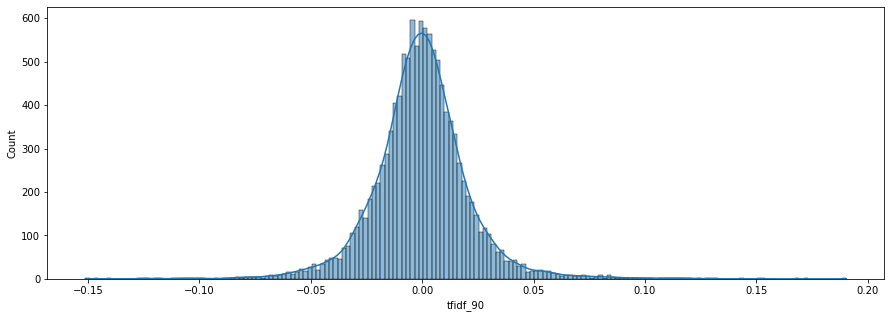

In [64]:
plt.figure(figsize=(15, 5))
sns.histplot(data=visu, x='tfidf_90', kde=True)

plt.show()

Hier zie je een histplot deze toont de verdeling van tfidf_90. Je kunt zien dat het een normaal verdeling is. 

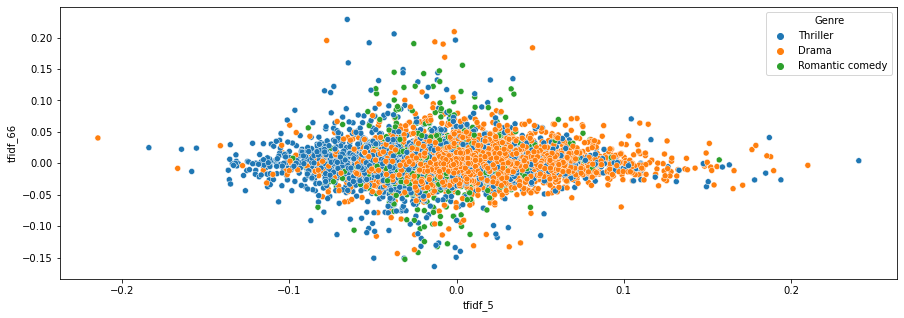

In [87]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=visu, x='tfidf_5', y='tfidf_66', hue='Genre')
plt.show()

In deze scatterplot kun je zien dat er veel overlap is in de genre en de tfidf. Je ziet wel dat het genre Thriller meer aan de linkerkant zit, het genre Romantic comedy in het midden en het genre Drama vooral aan de rechterkant zit. 

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Modeleren</div>
    <a name='toon'></a>
</div>

Het voorspellen van het genre is een classificatie probleem, want je gaat de films classificeren op basis van het genre. Daarom kiezen wij voor een decisiontree model om aantetonen dat de pipeline werkt.

We beginnen met het splitsen van de X en de y in een train en test split.

In [46]:
# X en y definiëren
X = df.drop(['Genre','Titel', 'Beschrijving'], axis=1)
y = df['Genre']

# Toepassen van train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.25)

Nu de data is gesplits gaan we kijken hoe het decision tree model scoort

In [47]:
dt = DecisionTreeClassifier(random_state=42)

#het model fitten
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

# accuracy berekenen
accuracy = accuracy_score(y_test, y_pred)
print(f"Nauwkeurigheid: {accuracy}")

Nauwkeurigheid: 0.13654618473895583


<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:40px; font-weight:bold;">Bronnen</div>
    <a name='bron'></a>
</div>

CMU Movie Summary Corpus. (n.d.). http://www.cs.cmu.edu/~ark/personas/

Please cite this paper if you write any papers involving the use of the data (van de Movie Summary Corpus):

    Learning Latent Personas of Film Characters
    David Bamman, Brendan O'Connor, and Noah A. Smith
    ACL 2013, Sofia, Bulgaria, August 2013

RapidAPI. (z.d.). MoviesDatabase API: How to use the API with free API key | RapidAPI. https://rapidapi.com/SAdrian/api/moviesdatabase/details
